# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

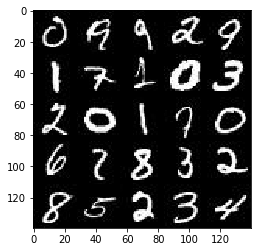

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
print(mnist_images.shape)

(25, 28, 28, 1)


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

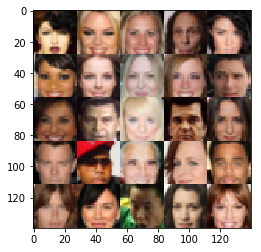

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [5]:
mnist_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 for MNIST and 28x28x3 for CelebA
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # No batch normalization here
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now
    
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now

        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)   
        # 4x4x256 now

        flat = tf.reshape(relu3, (-1, 4*4*256))
        # dropout
        flat_drop = tf.nn.dropout(flat, keep_prob=0.8)
        #flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat_drop, 1, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = (not is_train)):        
        # First fully connected layer
        x0 = tf.layers.dense(z, 2*2*1024, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 2, 2, 1024))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # 2x2x1024 now
        
        x1 = tf.layers.conv2d_transpose(x0, 512, 2, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, keep_prob=0.5)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=0.5)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # dropout
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits) 
                
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # label smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
      
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Filter variables with names that are in D and G scope names
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
 
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    # Scale of real images
    REAL_SCALE = 0.5 
    
    # Create GAN
    _, im_width, im_height, im_channel = data_shape
    input_real, input_z, l_rate = model_inputs(im_width, im_height, im_channel, z_dim) 
    d_loss, g_loss = model_loss(input_real, input_z, im_channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   
 
    # For printing and showing
    losses = []
    show_every = 100
    print_every = 10
    n_images=16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers  (run g_opt twice for each d_opt to avoid fast convergence of D)
                _ = sess.run(d_opt, feed_dict={input_real: batch_images/REAL_SCALE, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images/REAL_SCALE})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images/REAL_SCALE})
                
                if steps % print_every == 0:
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Bacth {}: Epoch {}/{}...".format(steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, im_channel, data_image_mode)
    
    # Not used this time
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Bacth 10: Epoch 1/2... Discriminator Loss: 2.0320... Generator Loss: 0.3725
Bacth 20: Epoch 1/2... Discriminator Loss: 2.7355... Generator Loss: 0.2990
Bacth 30: Epoch 1/2... Discriminator Loss: 2.2712... Generator Loss: 0.4595
Bacth 40: Epoch 1/2... Discriminator Loss: 2.0886... Generator Loss: 0.7760
Bacth 50: Epoch 1/2... Discriminator Loss: 2.2862... Generator Loss: 1.1321
Bacth 60: Epoch 1/2... Discriminator Loss: 1.5764... Generator Loss: 1.1310
Bacth 70: Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.9891
Bacth 80: Epoch 1/2... Discriminator Loss: 1.5588... Generator Loss: 0.7927
Bacth 90: Epoch 1/2... Discriminator Loss: 1.7943... Generator Loss: 0.6548
Bacth 100: Epoch 1/2... Discriminator Loss: 1.6582... Generator Loss: 0.6311


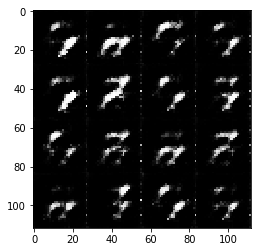

Bacth 110: Epoch 1/2... Discriminator Loss: 1.9831... Generator Loss: 0.8066
Bacth 120: Epoch 1/2... Discriminator Loss: 1.7866... Generator Loss: 1.0481
Bacth 130: Epoch 1/2... Discriminator Loss: 1.9316... Generator Loss: 0.6841
Bacth 140: Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.8005
Bacth 150: Epoch 1/2... Discriminator Loss: 2.1876... Generator Loss: 0.4890
Bacth 160: Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.7106
Bacth 170: Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.8337
Bacth 180: Epoch 1/2... Discriminator Loss: 1.7578... Generator Loss: 0.7079
Bacth 190: Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.2555
Bacth 200: Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 1.1550


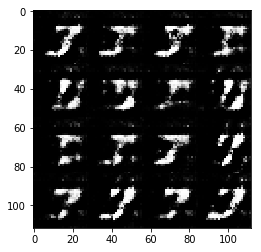

Bacth 210: Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.8824
Bacth 220: Epoch 1/2... Discriminator Loss: 2.0354... Generator Loss: 0.6977
Bacth 230: Epoch 1/2... Discriminator Loss: 1.8572... Generator Loss: 0.6510
Bacth 240: Epoch 1/2... Discriminator Loss: 1.7179... Generator Loss: 0.6571
Bacth 250: Epoch 1/2... Discriminator Loss: 1.9916... Generator Loss: 0.7959
Bacth 260: Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 0.5928
Bacth 270: Epoch 1/2... Discriminator Loss: 1.5767... Generator Loss: 0.9527
Bacth 280: Epoch 1/2... Discriminator Loss: 1.6240... Generator Loss: 0.7288
Bacth 290: Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 1.1159
Bacth 300: Epoch 1/2... Discriminator Loss: 1.8726... Generator Loss: 0.6338


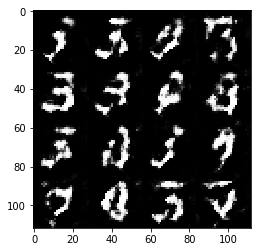

Bacth 310: Epoch 1/2... Discriminator Loss: 1.7199... Generator Loss: 1.1014
Bacth 320: Epoch 1/2... Discriminator Loss: 1.5859... Generator Loss: 0.9609
Bacth 330: Epoch 1/2... Discriminator Loss: 1.8685... Generator Loss: 0.4890
Bacth 340: Epoch 1/2... Discriminator Loss: 1.6804... Generator Loss: 0.7626
Bacth 350: Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.7889
Bacth 360: Epoch 1/2... Discriminator Loss: 1.6229... Generator Loss: 0.6893
Bacth 370: Epoch 1/2... Discriminator Loss: 1.7036... Generator Loss: 0.9638
Bacth 380: Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.7235
Bacth 390: Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 0.7491
Bacth 400: Epoch 1/2... Discriminator Loss: 1.8757... Generator Loss: 0.5997


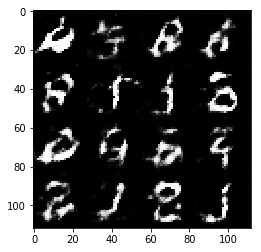

Bacth 410: Epoch 1/2... Discriminator Loss: 1.9098... Generator Loss: 0.6541
Bacth 420: Epoch 1/2... Discriminator Loss: 1.8537... Generator Loss: 0.9765
Bacth 430: Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 0.8234
Bacth 440: Epoch 1/2... Discriminator Loss: 1.9471... Generator Loss: 0.8102
Bacth 450: Epoch 1/2... Discriminator Loss: 1.8317... Generator Loss: 1.1538
Bacth 460: Epoch 1/2... Discriminator Loss: 1.6760... Generator Loss: 0.7098
Bacth 470: Epoch 1/2... Discriminator Loss: 1.7402... Generator Loss: 0.8505
Bacth 480: Epoch 1/2... Discriminator Loss: 1.5867... Generator Loss: 0.8728
Bacth 490: Epoch 1/2... Discriminator Loss: 1.8323... Generator Loss: 0.9817
Bacth 500: Epoch 1/2... Discriminator Loss: 1.6115... Generator Loss: 0.8131


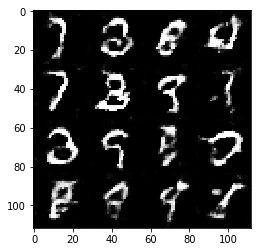

Bacth 510: Epoch 1/2... Discriminator Loss: 1.7968... Generator Loss: 1.0024
Bacth 520: Epoch 1/2... Discriminator Loss: 1.7995... Generator Loss: 0.7748
Bacth 530: Epoch 1/2... Discriminator Loss: 1.6438... Generator Loss: 0.5409
Bacth 540: Epoch 1/2... Discriminator Loss: 1.6821... Generator Loss: 1.0288
Bacth 550: Epoch 1/2... Discriminator Loss: 1.8447... Generator Loss: 0.5706
Bacth 560: Epoch 1/2... Discriminator Loss: 1.6586... Generator Loss: 1.1314
Bacth 570: Epoch 1/2... Discriminator Loss: 1.5674... Generator Loss: 0.5454
Bacth 580: Epoch 1/2... Discriminator Loss: 1.5857... Generator Loss: 0.7126
Bacth 590: Epoch 1/2... Discriminator Loss: 1.5542... Generator Loss: 0.7649
Bacth 600: Epoch 1/2... Discriminator Loss: 1.8350... Generator Loss: 0.6145


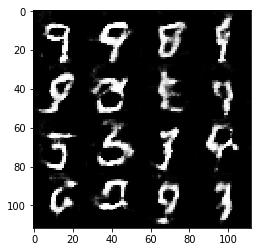

Bacth 610: Epoch 1/2... Discriminator Loss: 1.8412... Generator Loss: 0.6032
Bacth 620: Epoch 1/2... Discriminator Loss: 1.7492... Generator Loss: 0.5049
Bacth 630: Epoch 1/2... Discriminator Loss: 1.6907... Generator Loss: 0.6426
Bacth 640: Epoch 1/2... Discriminator Loss: 1.7096... Generator Loss: 0.6861
Bacth 650: Epoch 1/2... Discriminator Loss: 1.6999... Generator Loss: 0.5445
Bacth 660: Epoch 1/2... Discriminator Loss: 1.6886... Generator Loss: 0.6793
Bacth 670: Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.9775
Bacth 680: Epoch 1/2... Discriminator Loss: 1.7085... Generator Loss: 0.8528
Bacth 690: Epoch 1/2... Discriminator Loss: 1.6086... Generator Loss: 0.5464
Bacth 700: Epoch 1/2... Discriminator Loss: 1.7485... Generator Loss: 0.9012


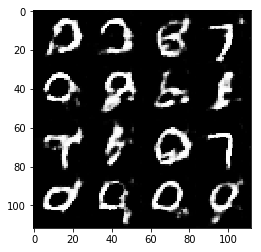

Bacth 710: Epoch 1/2... Discriminator Loss: 1.6713... Generator Loss: 0.7482
Bacth 720: Epoch 1/2... Discriminator Loss: 1.5034... Generator Loss: 0.9682
Bacth 730: Epoch 1/2... Discriminator Loss: 1.7011... Generator Loss: 0.5112
Bacth 740: Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 0.9769
Bacth 750: Epoch 1/2... Discriminator Loss: 1.6781... Generator Loss: 0.7571
Bacth 760: Epoch 1/2... Discriminator Loss: 1.5977... Generator Loss: 0.6627
Bacth 770: Epoch 1/2... Discriminator Loss: 1.8383... Generator Loss: 0.5066
Bacth 780: Epoch 1/2... Discriminator Loss: 1.9459... Generator Loss: 1.4186
Bacth 790: Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 0.9118
Bacth 800: Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.6859


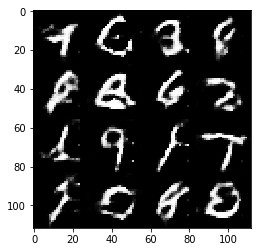

Bacth 810: Epoch 1/2... Discriminator Loss: 1.5919... Generator Loss: 0.9622
Bacth 820: Epoch 1/2... Discriminator Loss: 1.6037... Generator Loss: 0.8361
Bacth 830: Epoch 1/2... Discriminator Loss: 1.7946... Generator Loss: 0.6742
Bacth 840: Epoch 1/2... Discriminator Loss: 1.6544... Generator Loss: 0.9565
Bacth 850: Epoch 1/2... Discriminator Loss: 1.7377... Generator Loss: 1.1878
Bacth 860: Epoch 1/2... Discriminator Loss: 1.6828... Generator Loss: 0.8362
Bacth 870: Epoch 1/2... Discriminator Loss: 1.5752... Generator Loss: 0.6625
Bacth 880: Epoch 1/2... Discriminator Loss: 1.8235... Generator Loss: 0.7472
Bacth 890: Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 0.6517
Bacth 900: Epoch 1/2... Discriminator Loss: 1.8704... Generator Loss: 0.6354


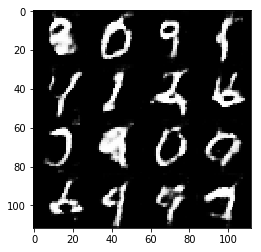

Bacth 910: Epoch 1/2... Discriminator Loss: 2.0791... Generator Loss: 1.5310
Bacth 920: Epoch 1/2... Discriminator Loss: 1.7157... Generator Loss: 0.6923
Bacth 930: Epoch 1/2... Discriminator Loss: 1.7403... Generator Loss: 1.3776
Bacth 940: Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.7955
Bacth 950: Epoch 1/2... Discriminator Loss: 1.6662... Generator Loss: 0.7264
Bacth 960: Epoch 1/2... Discriminator Loss: 1.9433... Generator Loss: 0.4443
Bacth 970: Epoch 1/2... Discriminator Loss: 2.3004... Generator Loss: 1.2782
Bacth 980: Epoch 1/2... Discriminator Loss: 1.8746... Generator Loss: 0.6986
Bacth 990: Epoch 1/2... Discriminator Loss: 1.9025... Generator Loss: 0.7836
Bacth 1000: Epoch 1/2... Discriminator Loss: 2.3265... Generator Loss: 1.0773


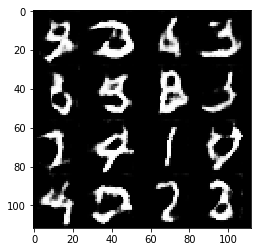

Bacth 1010: Epoch 1/2... Discriminator Loss: 2.5329... Generator Loss: 0.5981
Bacth 1020: Epoch 1/2... Discriminator Loss: 1.8981... Generator Loss: 1.0292
Bacth 1030: Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.9242
Bacth 1040: Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.8678
Bacth 1050: Epoch 1/2... Discriminator Loss: 1.7101... Generator Loss: 0.7100
Bacth 1060: Epoch 1/2... Discriminator Loss: 1.8831... Generator Loss: 1.0216
Bacth 1070: Epoch 1/2... Discriminator Loss: 1.7819... Generator Loss: 1.0469
Bacth 1080: Epoch 1/2... Discriminator Loss: 1.8688... Generator Loss: 0.9878
Bacth 1090: Epoch 1/2... Discriminator Loss: 2.3234... Generator Loss: 1.1731
Bacth 1100: Epoch 1/2... Discriminator Loss: 1.6794... Generator Loss: 1.0013


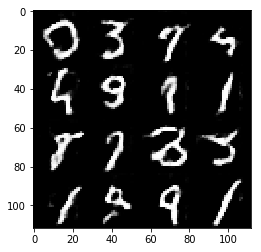

Bacth 1110: Epoch 1/2... Discriminator Loss: 2.6035... Generator Loss: 0.5274
Bacth 1120: Epoch 1/2... Discriminator Loss: 1.8641... Generator Loss: 1.8776
Bacth 1130: Epoch 1/2... Discriminator Loss: 2.0296... Generator Loss: 0.7875
Bacth 1140: Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.4939
Bacth 1150: Epoch 1/2... Discriminator Loss: 1.9950... Generator Loss: 0.9691
Bacth 1160: Epoch 1/2... Discriminator Loss: 2.5509... Generator Loss: 0.9066
Bacth 1170: Epoch 1/2... Discriminator Loss: 2.5716... Generator Loss: 1.0107
Bacth 1180: Epoch 1/2... Discriminator Loss: 2.2494... Generator Loss: 0.2522
Bacth 1190: Epoch 1/2... Discriminator Loss: 2.6345... Generator Loss: 0.9083
Bacth 1200: Epoch 1/2... Discriminator Loss: 2.7393... Generator Loss: 0.6670


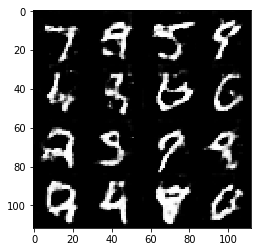

Bacth 1210: Epoch 1/2... Discriminator Loss: 3.2611... Generator Loss: 1.2210
Bacth 1220: Epoch 1/2... Discriminator Loss: 2.9735... Generator Loss: 0.7062
Bacth 1230: Epoch 1/2... Discriminator Loss: 4.1300... Generator Loss: 1.6102
Bacth 1240: Epoch 1/2... Discriminator Loss: 3.5610... Generator Loss: 1.0299
Bacth 1250: Epoch 1/2... Discriminator Loss: 2.2622... Generator Loss: 0.2155
Bacth 1260: Epoch 1/2... Discriminator Loss: 1.4865... Generator Loss: 0.6152
Bacth 1270: Epoch 1/2... Discriminator Loss: 1.6529... Generator Loss: 0.4867
Bacth 1280: Epoch 1/2... Discriminator Loss: 2.4734... Generator Loss: 1.1819
Bacth 1290: Epoch 1/2... Discriminator Loss: 2.3657... Generator Loss: 0.2941
Bacth 1300: Epoch 1/2... Discriminator Loss: 4.0960... Generator Loss: 0.8220


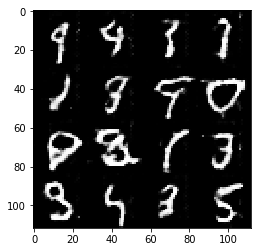

Bacth 1310: Epoch 1/2... Discriminator Loss: 4.8113... Generator Loss: 1.6181
Bacth 1320: Epoch 1/2... Discriminator Loss: 1.5688... Generator Loss: 1.9260
Bacth 1330: Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.6621
Bacth 1340: Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 1.0090
Bacth 1350: Epoch 1/2... Discriminator Loss: 2.0647... Generator Loss: 1.1197
Bacth 1360: Epoch 1/2... Discriminator Loss: 2.8416... Generator Loss: 0.5377
Bacth 1370: Epoch 1/2... Discriminator Loss: 3.0958... Generator Loss: 0.6496
Bacth 1380: Epoch 1/2... Discriminator Loss: 2.8573... Generator Loss: 0.8132
Bacth 1390: Epoch 1/2... Discriminator Loss: 3.6152... Generator Loss: 1.0493
Bacth 1400: Epoch 1/2... Discriminator Loss: 6.3565... Generator Loss: 1.7075


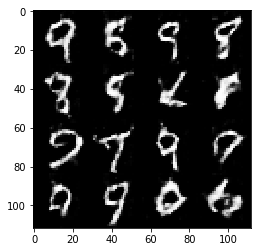

Bacth 1410: Epoch 1/2... Discriminator Loss: 1.6711... Generator Loss: 0.5425
Bacth 1420: Epoch 1/2... Discriminator Loss: 2.4808... Generator Loss: 0.9815
Bacth 1430: Epoch 1/2... Discriminator Loss: 3.3469... Generator Loss: 0.8390
Bacth 1440: Epoch 1/2... Discriminator Loss: 2.0062... Generator Loss: 1.3626
Bacth 1450: Epoch 1/2... Discriminator Loss: 3.2482... Generator Loss: 0.5948
Bacth 1460: Epoch 1/2... Discriminator Loss: 4.1121... Generator Loss: 0.9345
Bacth 1470: Epoch 1/2... Discriminator Loss: 4.8939... Generator Loss: 0.9708
Bacth 1480: Epoch 1/2... Discriminator Loss: 3.7987... Generator Loss: 1.4841
Bacth 1490: Epoch 1/2... Discriminator Loss: 5.1639... Generator Loss: 1.2918
Bacth 1500: Epoch 1/2... Discriminator Loss: 6.2257... Generator Loss: 2.3057


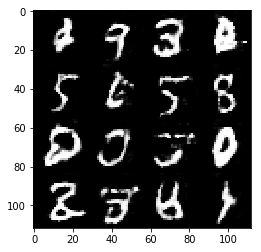

Bacth 1510: Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.5810
Bacth 1520: Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.6446
Bacth 1530: Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.6753
Bacth 1540: Epoch 1/2... Discriminator Loss: 2.1893... Generator Loss: 0.9214
Bacth 1550: Epoch 1/2... Discriminator Loss: 2.9097... Generator Loss: 0.8181
Bacth 1560: Epoch 1/2... Discriminator Loss: 3.6221... Generator Loss: 0.6533
Bacth 1570: Epoch 1/2... Discriminator Loss: 3.4353... Generator Loss: 0.5905
Bacth 1580: Epoch 1/2... Discriminator Loss: 4.0785... Generator Loss: 1.5791
Bacth 1590: Epoch 1/2... Discriminator Loss: 1.9036... Generator Loss: 1.4860
Bacth 1600: Epoch 1/2... Discriminator Loss: 3.8322... Generator Loss: 0.8377


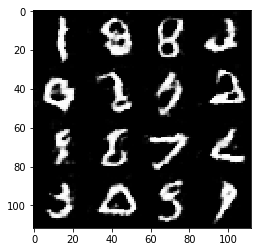

Bacth 1610: Epoch 1/2... Discriminator Loss: 3.7995... Generator Loss: 1.0205
Bacth 1620: Epoch 1/2... Discriminator Loss: 4.0395... Generator Loss: 1.0399
Bacth 1630: Epoch 1/2... Discriminator Loss: 4.1663... Generator Loss: 1.5296
Bacth 1640: Epoch 1/2... Discriminator Loss: 4.8039... Generator Loss: 0.9127
Bacth 1650: Epoch 1/2... Discriminator Loss: 5.5639... Generator Loss: 1.4181
Bacth 1660: Epoch 1/2... Discriminator Loss: 2.3578... Generator Loss: 0.2416
Bacth 1670: Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 1.0802
Bacth 1680: Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.8797
Bacth 1690: Epoch 1/2... Discriminator Loss: 2.1045... Generator Loss: 0.8005
Bacth 1700: Epoch 1/2... Discriminator Loss: 3.5577... Generator Loss: 2.7058


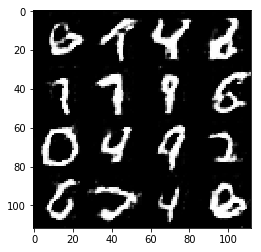

Bacth 1710: Epoch 1/2... Discriminator Loss: 4.7848... Generator Loss: 1.5397
Bacth 1720: Epoch 1/2... Discriminator Loss: 4.3187... Generator Loss: 0.7055
Bacth 1730: Epoch 1/2... Discriminator Loss: 4.9197... Generator Loss: 1.4545
Bacth 1740: Epoch 1/2... Discriminator Loss: 5.9829... Generator Loss: 1.9639
Bacth 1750: Epoch 1/2... Discriminator Loss: 5.8478... Generator Loss: 0.8978
Bacth 1760: Epoch 1/2... Discriminator Loss: 5.8041... Generator Loss: 0.8676
Bacth 1770: Epoch 1/2... Discriminator Loss: 6.3707... Generator Loss: 1.6825
Bacth 1780: Epoch 1/2... Discriminator Loss: 5.7457... Generator Loss: 1.3126
Bacth 1790: Epoch 1/2... Discriminator Loss: 5.5314... Generator Loss: 0.3354
Bacth 1800: Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.0399


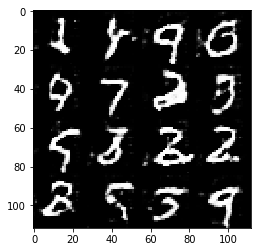

Bacth 1810: Epoch 1/2... Discriminator Loss: 2.0832... Generator Loss: 0.9813
Bacth 1820: Epoch 1/2... Discriminator Loss: 5.4572... Generator Loss: 1.5337
Bacth 1830: Epoch 1/2... Discriminator Loss: 5.3982... Generator Loss: 1.2219
Bacth 1840: Epoch 1/2... Discriminator Loss: 5.3695... Generator Loss: 1.0088
Bacth 1850: Epoch 1/2... Discriminator Loss: 5.6635... Generator Loss: 0.8970
Bacth 1860: Epoch 1/2... Discriminator Loss: 7.4045... Generator Loss: 2.2988
Bacth 1870: Epoch 1/2... Discriminator Loss: 5.2958... Generator Loss: 3.1326
Bacth 10: Epoch 2/2... Discriminator Loss: 4.1663... Generator Loss: 0.9585
Bacth 20: Epoch 2/2... Discriminator Loss: 5.9497... Generator Loss: 1.0804
Bacth 30: Epoch 2/2... Discriminator Loss: 6.3915... Generator Loss: 1.2494
Bacth 40: Epoch 2/2... Discriminator Loss: 4.6115... Generator Loss: 0.1333
Bacth 50: Epoch 2/2... Discriminator Loss: 6.4442... Generator Loss: 1.7062
Bacth 60: Epoch 2/2... Discriminator Loss: 6.7739... Generator Loss: 1.455

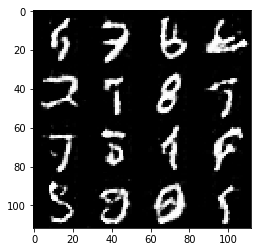

Bacth 110: Epoch 2/2... Discriminator Loss: 6.7585... Generator Loss: 0.7682
Bacth 120: Epoch 2/2... Discriminator Loss: 7.2124... Generator Loss: 0.9514
Bacth 130: Epoch 2/2... Discriminator Loss: 6.7582... Generator Loss: 0.5860
Bacth 140: Epoch 2/2... Discriminator Loss: 4.2987... Generator Loss: 1.8496
Bacth 150: Epoch 2/2... Discriminator Loss: 6.3445... Generator Loss: 0.9420
Bacth 160: Epoch 2/2... Discriminator Loss: 6.8254... Generator Loss: 0.8972
Bacth 170: Epoch 2/2... Discriminator Loss: 6.8279... Generator Loss: 1.4586
Bacth 180: Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 1.4164
Bacth 190: Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 1.1799
Bacth 200: Epoch 2/2... Discriminator Loss: 1.6341... Generator Loss: 1.2069


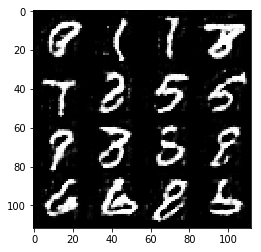

Bacth 210: Epoch 2/2... Discriminator Loss: 5.1795... Generator Loss: 0.9201
Bacth 220: Epoch 2/2... Discriminator Loss: 5.0861... Generator Loss: 2.4480
Bacth 230: Epoch 2/2... Discriminator Loss: 6.3470... Generator Loss: 1.6316
Bacth 240: Epoch 2/2... Discriminator Loss: 6.4359... Generator Loss: 1.5286
Bacth 250: Epoch 2/2... Discriminator Loss: 7.3251... Generator Loss: 1.5280
Bacth 260: Epoch 2/2... Discriminator Loss: 6.2905... Generator Loss: 2.2887
Bacth 270: Epoch 2/2... Discriminator Loss: 6.8815... Generator Loss: 1.1990
Bacth 280: Epoch 2/2... Discriminator Loss: 7.1700... Generator Loss: 1.4589
Bacth 290: Epoch 2/2... Discriminator Loss: 6.9407... Generator Loss: 0.8968
Bacth 300: Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 1.1776


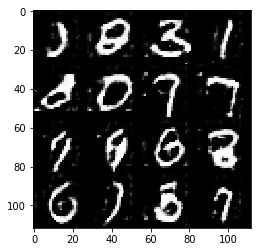

Bacth 310: Epoch 2/2... Discriminator Loss: 1.5186... Generator Loss: 0.6000
Bacth 320: Epoch 2/2... Discriminator Loss: 2.1854... Generator Loss: 1.9961
Bacth 330: Epoch 2/2... Discriminator Loss: 4.7370... Generator Loss: 1.0359
Bacth 340: Epoch 2/2... Discriminator Loss: 6.1161... Generator Loss: 0.8900
Bacth 350: Epoch 2/2... Discriminator Loss: 6.1588... Generator Loss: 0.9738
Bacth 360: Epoch 2/2... Discriminator Loss: 6.5306... Generator Loss: 0.8131
Bacth 370: Epoch 2/2... Discriminator Loss: 6.5026... Generator Loss: 1.4113
Bacth 380: Epoch 2/2... Discriminator Loss: 6.4734... Generator Loss: 1.6100
Bacth 390: Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.6121
Bacth 400: Epoch 2/2... Discriminator Loss: 2.4367... Generator Loss: 1.6300


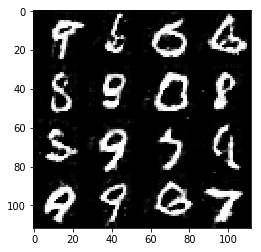

Bacth 410: Epoch 2/2... Discriminator Loss: 6.8941... Generator Loss: 0.7090
Bacth 420: Epoch 2/2... Discriminator Loss: 7.1999... Generator Loss: 2.1268
Bacth 430: Epoch 2/2... Discriminator Loss: 6.7365... Generator Loss: 1.2210
Bacth 440: Epoch 2/2... Discriminator Loss: 7.2756... Generator Loss: 1.9329
Bacth 450: Epoch 2/2... Discriminator Loss: 7.6777... Generator Loss: 1.1830
Bacth 460: Epoch 2/2... Discriminator Loss: 8.3815... Generator Loss: 1.2314
Bacth 470: Epoch 2/2... Discriminator Loss: 6.9657... Generator Loss: 1.2765
Bacth 480: Epoch 2/2... Discriminator Loss: 7.6040... Generator Loss: 1.1639
Bacth 490: Epoch 2/2... Discriminator Loss: 8.1928... Generator Loss: 2.2661
Bacth 500: Epoch 2/2... Discriminator Loss: 7.7354... Generator Loss: 1.5621


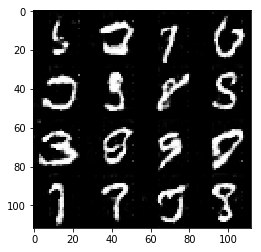

Bacth 510: Epoch 2/2... Discriminator Loss: 8.3735... Generator Loss: 2.1021
Bacth 520: Epoch 2/2... Discriminator Loss: 8.2113... Generator Loss: 1.6004
Bacth 530: Epoch 2/2... Discriminator Loss: 7.6214... Generator Loss: 1.7368
Bacth 540: Epoch 2/2... Discriminator Loss: 7.4748... Generator Loss: 1.0233
Bacth 550: Epoch 2/2... Discriminator Loss: 8.0043... Generator Loss: 2.4028
Bacth 560: Epoch 2/2... Discriminator Loss: 7.9831... Generator Loss: 1.4890
Bacth 570: Epoch 2/2... Discriminator Loss: 8.2433... Generator Loss: 1.2523
Bacth 580: Epoch 2/2... Discriminator Loss: 7.5486... Generator Loss: 1.1933
Bacth 590: Epoch 2/2... Discriminator Loss: 8.7556... Generator Loss: 2.5157
Bacth 600: Epoch 2/2... Discriminator Loss: 8.1650... Generator Loss: 0.8642


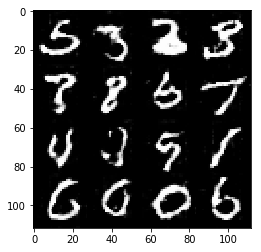

Bacth 610: Epoch 2/2... Discriminator Loss: 7.9389... Generator Loss: 1.6750
Bacth 620: Epoch 2/2... Discriminator Loss: 1.4960... Generator Loss: 0.7877
Bacth 630: Epoch 2/2... Discriminator Loss: 6.4605... Generator Loss: 1.4024
Bacth 640: Epoch 2/2... Discriminator Loss: 6.2980... Generator Loss: 1.4751
Bacth 650: Epoch 2/2... Discriminator Loss: 7.5789... Generator Loss: 1.8037
Bacth 660: Epoch 2/2... Discriminator Loss: 7.8693... Generator Loss: 1.9761
Bacth 670: Epoch 2/2... Discriminator Loss: 2.9702... Generator Loss: 1.0349
Bacth 680: Epoch 2/2... Discriminator Loss: 6.4495... Generator Loss: 0.6409
Bacth 690: Epoch 2/2... Discriminator Loss: 7.8761... Generator Loss: 1.9603
Bacth 700: Epoch 2/2... Discriminator Loss: 8.8569... Generator Loss: 2.7906


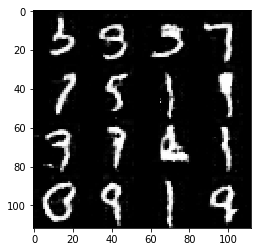

Bacth 710: Epoch 2/2... Discriminator Loss: 8.0149... Generator Loss: 0.9256
Bacth 720: Epoch 2/2... Discriminator Loss: 8.0445... Generator Loss: 1.8682
Bacth 730: Epoch 2/2... Discriminator Loss: 8.0791... Generator Loss: 1.5026
Bacth 740: Epoch 2/2... Discriminator Loss: 6.7531... Generator Loss: 1.6512
Bacth 750: Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 1.0807
Bacth 760: Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 1.1523
Bacth 770: Epoch 2/2... Discriminator Loss: 2.7972... Generator Loss: 0.8063
Bacth 780: Epoch 2/2... Discriminator Loss: 5.4329... Generator Loss: 1.7583
Bacth 790: Epoch 2/2... Discriminator Loss: 6.9519... Generator Loss: 2.1151
Bacth 800: Epoch 2/2... Discriminator Loss: 6.4131... Generator Loss: 0.9139


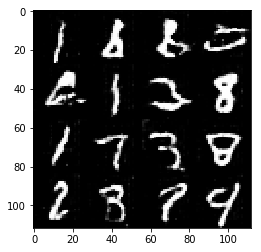

Bacth 810: Epoch 2/2... Discriminator Loss: 6.6363... Generator Loss: 1.5671
Bacth 820: Epoch 2/2... Discriminator Loss: 4.9995... Generator Loss: 2.4765
Bacth 830: Epoch 2/2... Discriminator Loss: 6.8391... Generator Loss: 0.9914
Bacth 840: Epoch 2/2... Discriminator Loss: 7.1196... Generator Loss: 1.8034
Bacth 850: Epoch 2/2... Discriminator Loss: 7.1635... Generator Loss: 0.9899
Bacth 860: Epoch 2/2... Discriminator Loss: 7.9302... Generator Loss: 2.3591
Bacth 870: Epoch 2/2... Discriminator Loss: 8.3777... Generator Loss: 1.4174
Bacth 880: Epoch 2/2... Discriminator Loss: 7.7379... Generator Loss: 1.1165
Bacth 890: Epoch 2/2... Discriminator Loss: 7.2019... Generator Loss: 1.1341
Bacth 900: Epoch 2/2... Discriminator Loss: 4.6489... Generator Loss: 0.4339


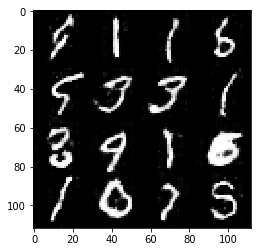

Bacth 910: Epoch 2/2... Discriminator Loss: 7.2267... Generator Loss: 1.1048
Bacth 920: Epoch 2/2... Discriminator Loss: 7.1129... Generator Loss: 1.3685
Bacth 930: Epoch 2/2... Discriminator Loss: 7.3960... Generator Loss: 0.4294
Bacth 940: Epoch 2/2... Discriminator Loss: 8.0323... Generator Loss: 1.3336
Bacth 950: Epoch 2/2... Discriminator Loss: 8.3015... Generator Loss: 1.5889
Bacth 960: Epoch 2/2... Discriminator Loss: 9.0015... Generator Loss: 3.1735
Bacth 970: Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.6305
Bacth 980: Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.2602
Bacth 990: Epoch 2/2... Discriminator Loss: 1.9458... Generator Loss: 1.8224
Bacth 1000: Epoch 2/2... Discriminator Loss: 3.3959... Generator Loss: 0.9355


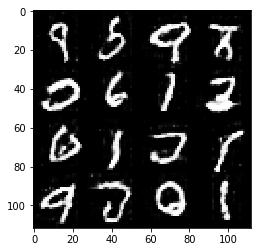

Bacth 1010: Epoch 2/2... Discriminator Loss: 5.0398... Generator Loss: 2.8435
Bacth 1020: Epoch 2/2... Discriminator Loss: 4.9168... Generator Loss: 1.0261
Bacth 1030: Epoch 2/2... Discriminator Loss: 4.6541... Generator Loss: 1.5668
Bacth 1040: Epoch 2/2... Discriminator Loss: 5.0367... Generator Loss: 0.6846
Bacth 1050: Epoch 2/2... Discriminator Loss: 5.0173... Generator Loss: 1.5448
Bacth 1060: Epoch 2/2... Discriminator Loss: 5.6605... Generator Loss: 1.1759
Bacth 1070: Epoch 2/2... Discriminator Loss: 5.8582... Generator Loss: 1.9549
Bacth 1080: Epoch 2/2... Discriminator Loss: 6.1066... Generator Loss: 0.8797
Bacth 1090: Epoch 2/2... Discriminator Loss: 7.5394... Generator Loss: 4.1348
Bacth 1100: Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.7258


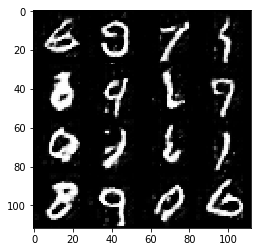

Bacth 1110: Epoch 2/2... Discriminator Loss: 1.8367... Generator Loss: 0.9796
Bacth 1120: Epoch 2/2... Discriminator Loss: 4.5255... Generator Loss: 1.9039
Bacth 1130: Epoch 2/2... Discriminator Loss: 5.8279... Generator Loss: 0.9477
Bacth 1140: Epoch 2/2... Discriminator Loss: 6.0419... Generator Loss: 0.9401
Bacth 1150: Epoch 2/2... Discriminator Loss: 5.8866... Generator Loss: 0.9320
Bacth 1160: Epoch 2/2... Discriminator Loss: 6.2493... Generator Loss: 1.2879
Bacth 1170: Epoch 2/2... Discriminator Loss: 6.3801... Generator Loss: 0.8643
Bacth 1180: Epoch 2/2... Discriminator Loss: 6.7077... Generator Loss: 1.9007
Bacth 1190: Epoch 2/2... Discriminator Loss: 5.4315... Generator Loss: 0.7924
Bacth 1200: Epoch 2/2... Discriminator Loss: 6.6472... Generator Loss: 1.3277


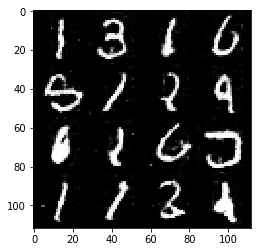

Bacth 1210: Epoch 2/2... Discriminator Loss: 7.3059... Generator Loss: 1.5025
Bacth 1220: Epoch 2/2... Discriminator Loss: 6.6244... Generator Loss: 0.8821
Bacth 1230: Epoch 2/2... Discriminator Loss: 6.5130... Generator Loss: 2.3429
Bacth 1240: Epoch 2/2... Discriminator Loss: 6.6778... Generator Loss: 2.1677
Bacth 1250: Epoch 2/2... Discriminator Loss: 6.9772... Generator Loss: 1.2526
Bacth 1260: Epoch 2/2... Discriminator Loss: 6.7151... Generator Loss: 1.5006
Bacth 1270: Epoch 2/2... Discriminator Loss: 6.9566... Generator Loss: 1.6050
Bacth 1280: Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 1.3982
Bacth 1290: Epoch 2/2... Discriminator Loss: 3.1841... Generator Loss: 1.6734
Bacth 1300: Epoch 2/2... Discriminator Loss: 6.6276... Generator Loss: 1.7776


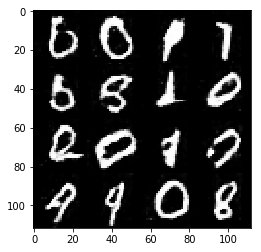

Bacth 1310: Epoch 2/2... Discriminator Loss: 7.0567... Generator Loss: 1.7094
Bacth 1320: Epoch 2/2... Discriminator Loss: 7.2188... Generator Loss: 1.8015
Bacth 1330: Epoch 2/2... Discriminator Loss: 7.5150... Generator Loss: 2.1626
Bacth 1340: Epoch 2/2... Discriminator Loss: 7.1335... Generator Loss: 1.4058
Bacth 1350: Epoch 2/2... Discriminator Loss: 7.2792... Generator Loss: 0.9229
Bacth 1360: Epoch 2/2... Discriminator Loss: 6.9829... Generator Loss: 2.5877
Bacth 1370: Epoch 2/2... Discriminator Loss: 6.8733... Generator Loss: 0.8275
Bacth 1380: Epoch 2/2... Discriminator Loss: 7.0645... Generator Loss: 1.7070
Bacth 1390: Epoch 2/2... Discriminator Loss: 6.8139... Generator Loss: 1.3034
Bacth 1400: Epoch 2/2... Discriminator Loss: 7.1668... Generator Loss: 1.3865


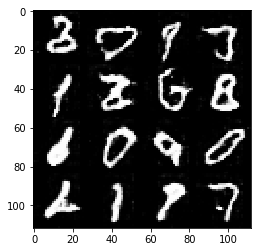

Bacth 1410: Epoch 2/2... Discriminator Loss: 7.3682... Generator Loss: 2.9099
Bacth 1420: Epoch 2/2... Discriminator Loss: 2.4808... Generator Loss: 1.3385
Bacth 1430: Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 2.0694
Bacth 1440: Epoch 2/2... Discriminator Loss: 1.9219... Generator Loss: 1.6651
Bacth 1450: Epoch 2/2... Discriminator Loss: 3.9460... Generator Loss: 1.1454
Bacth 1460: Epoch 2/2... Discriminator Loss: 4.9528... Generator Loss: 0.9137
Bacth 1470: Epoch 2/2... Discriminator Loss: 5.2379... Generator Loss: 1.8959
Bacth 1480: Epoch 2/2... Discriminator Loss: 5.8650... Generator Loss: 1.3419
Bacth 1490: Epoch 2/2... Discriminator Loss: 6.3358... Generator Loss: 3.0059
Bacth 1500: Epoch 2/2... Discriminator Loss: 6.5346... Generator Loss: 1.3089


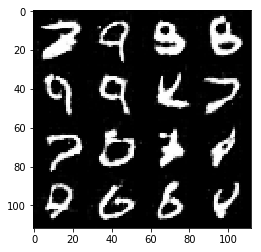

Bacth 1510: Epoch 2/2... Discriminator Loss: 6.4448... Generator Loss: 2.2830
Bacth 1520: Epoch 2/2... Discriminator Loss: 5.6581... Generator Loss: 0.6264
Bacth 1530: Epoch 2/2... Discriminator Loss: 5.7463... Generator Loss: 2.1794
Bacth 1540: Epoch 2/2... Discriminator Loss: 6.2125... Generator Loss: 1.6711
Bacth 1550: Epoch 2/2... Discriminator Loss: 6.7261... Generator Loss: 1.4431
Bacth 1560: Epoch 2/2... Discriminator Loss: 3.7815... Generator Loss: 2.0420
Bacth 1570: Epoch 2/2... Discriminator Loss: 6.5653... Generator Loss: 2.0076
Bacth 1580: Epoch 2/2... Discriminator Loss: 6.9432... Generator Loss: 1.3510
Bacth 1590: Epoch 2/2... Discriminator Loss: 6.9928... Generator Loss: 1.9552
Bacth 1600: Epoch 2/2... Discriminator Loss: 6.9892... Generator Loss: 1.4541


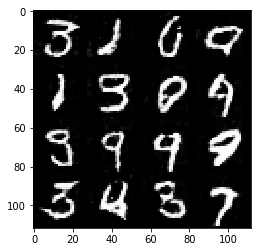

Bacth 1610: Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 3.3367
Bacth 1620: Epoch 2/2... Discriminator Loss: 3.0267... Generator Loss: 1.5984
Bacth 1630: Epoch 2/2... Discriminator Loss: 5.6898... Generator Loss: 1.0731
Bacth 1640: Epoch 2/2... Discriminator Loss: 6.3075... Generator Loss: 1.0867
Bacth 1650: Epoch 2/2... Discriminator Loss: 6.6912... Generator Loss: 1.2520
Bacth 1660: Epoch 2/2... Discriminator Loss: 6.4517... Generator Loss: 1.4544
Bacth 1670: Epoch 2/2... Discriminator Loss: 6.9116... Generator Loss: 2.8204
Bacth 1680: Epoch 2/2... Discriminator Loss: 5.9468... Generator Loss: 1.7702
Bacth 1690: Epoch 2/2... Discriminator Loss: 7.0495... Generator Loss: 1.1165
Bacth 1700: Epoch 2/2... Discriminator Loss: 5.0646... Generator Loss: 1.3098


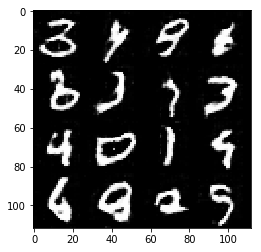

Bacth 1710: Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 1.2455
Bacth 1720: Epoch 2/2... Discriminator Loss: 5.1280... Generator Loss: 1.8935
Bacth 1730: Epoch 2/2... Discriminator Loss: 5.0263... Generator Loss: 1.7304
Bacth 1740: Epoch 2/2... Discriminator Loss: 5.8395... Generator Loss: 1.9123
Bacth 1750: Epoch 2/2... Discriminator Loss: 5.4432... Generator Loss: 1.7286
Bacth 1760: Epoch 2/2... Discriminator Loss: 5.9840... Generator Loss: 1.9388
Bacth 1770: Epoch 2/2... Discriminator Loss: 6.0308... Generator Loss: 1.6374
Bacth 1780: Epoch 2/2... Discriminator Loss: 5.9815... Generator Loss: 2.6649
Bacth 1790: Epoch 2/2... Discriminator Loss: 6.4265... Generator Loss: 1.0878
Bacth 1800: Epoch 2/2... Discriminator Loss: 5.8172... Generator Loss: 1.0317


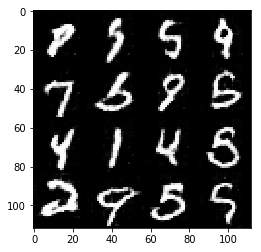

Bacth 1810: Epoch 2/2... Discriminator Loss: 5.8291... Generator Loss: 1.0944
Bacth 1820: Epoch 2/2... Discriminator Loss: 6.4418... Generator Loss: 1.3543
Bacth 1830: Epoch 2/2... Discriminator Loss: 6.0083... Generator Loss: 1.9351
Bacth 1840: Epoch 2/2... Discriminator Loss: 4.0897... Generator Loss: 1.1575
Bacth 1850: Epoch 2/2... Discriminator Loss: 5.2173... Generator Loss: 2.1444
Bacth 1860: Epoch 2/2... Discriminator Loss: 5.9887... Generator Loss: 2.1769
Bacth 1870: Epoch 2/2... Discriminator Loss: 5.3970... Generator Loss: 1.1634


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Bacth 10: Epoch 1/1... Discriminator Loss: 4.2895... Generator Loss: 0.0591
Bacth 20: Epoch 1/1... Discriminator Loss: 3.0872... Generator Loss: 0.3896
Bacth 30: Epoch 1/1... Discriminator Loss: 2.2435... Generator Loss: 0.6679
Bacth 40: Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 1.2847
Bacth 50: Epoch 1/1... Discriminator Loss: 1.9497... Generator Loss: 1.1040
Bacth 60: Epoch 1/1... Discriminator Loss: 2.2235... Generator Loss: 0.4281
Bacth 70: Epoch 1/1... Discriminator Loss: 1.8261... Generator Loss: 0.9775
Bacth 80: Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 0.9211
Bacth 90: Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.6374
Bacth 100: Epoch 1/1... Discriminator Loss: 1.7542... Generator Loss: 0.5089


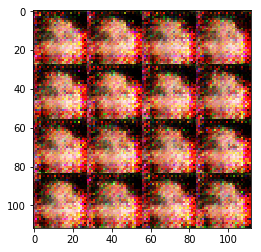

Bacth 110: Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.3285
Bacth 120: Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6900
Bacth 130: Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.4193
Bacth 140: Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 2.3300
Bacth 150: Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 0.9716
Bacth 160: Epoch 1/1... Discriminator Loss: 2.3692... Generator Loss: 0.2907
Bacth 170: Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.6954
Bacth 180: Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.5265
Bacth 190: Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 0.4097
Bacth 200: Epoch 1/1... Discriminator Loss: 1.6752... Generator Loss: 0.4123


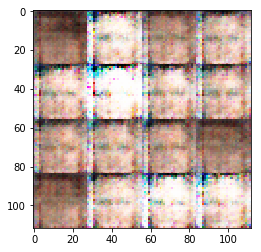

Bacth 210: Epoch 1/1... Discriminator Loss: 1.8659... Generator Loss: 0.4765
Bacth 220: Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.6653
Bacth 230: Epoch 1/1... Discriminator Loss: 1.8624... Generator Loss: 0.5638
Bacth 240: Epoch 1/1... Discriminator Loss: 1.6485... Generator Loss: 0.6916
Bacth 250: Epoch 1/1... Discriminator Loss: 1.9103... Generator Loss: 0.6333
Bacth 260: Epoch 1/1... Discriminator Loss: 1.8469... Generator Loss: 0.6498
Bacth 270: Epoch 1/1... Discriminator Loss: 1.8235... Generator Loss: 0.6515
Bacth 280: Epoch 1/1... Discriminator Loss: 1.8827... Generator Loss: 0.6498
Bacth 290: Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.8439
Bacth 300: Epoch 1/1... Discriminator Loss: 2.1213... Generator Loss: 0.5384


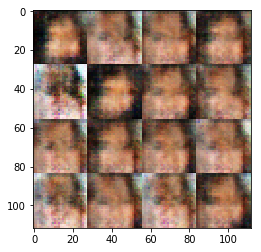

Bacth 310: Epoch 1/1... Discriminator Loss: 2.1409... Generator Loss: 0.3981
Bacth 320: Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.8009
Bacth 330: Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.7052
Bacth 340: Epoch 1/1... Discriminator Loss: 1.7524... Generator Loss: 0.6672
Bacth 350: Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.7819
Bacth 360: Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8671
Bacth 370: Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.9025
Bacth 380: Epoch 1/1... Discriminator Loss: 1.6645... Generator Loss: 0.7255
Bacth 390: Epoch 1/1... Discriminator Loss: 1.8068... Generator Loss: 0.5962
Bacth 400: Epoch 1/1... Discriminator Loss: 1.9085... Generator Loss: 0.5050


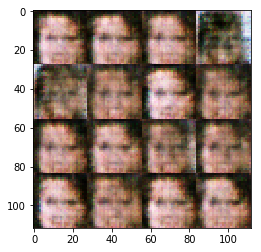

Bacth 410: Epoch 1/1... Discriminator Loss: 1.8807... Generator Loss: 0.6353
Bacth 420: Epoch 1/1... Discriminator Loss: 2.1626... Generator Loss: 0.6400
Bacth 430: Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.7734
Bacth 440: Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.7877
Bacth 450: Epoch 1/1... Discriminator Loss: 1.8005... Generator Loss: 0.6513
Bacth 460: Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.6605
Bacth 470: Epoch 1/1... Discriminator Loss: 1.9585... Generator Loss: 0.7430
Bacth 480: Epoch 1/1... Discriminator Loss: 1.6644... Generator Loss: 0.8068
Bacth 490: Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.8474
Bacth 500: Epoch 1/1... Discriminator Loss: 1.7137... Generator Loss: 0.6505


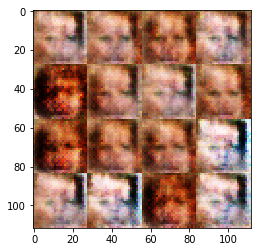

Bacth 510: Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.7458
Bacth 520: Epoch 1/1... Discriminator Loss: 1.7236... Generator Loss: 0.6344
Bacth 530: Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.7960
Bacth 540: Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.9202
Bacth 550: Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.7902
Bacth 560: Epoch 1/1... Discriminator Loss: 1.8658... Generator Loss: 0.7254
Bacth 570: Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.8079
Bacth 580: Epoch 1/1... Discriminator Loss: 1.7971... Generator Loss: 0.6317
Bacth 590: Epoch 1/1... Discriminator Loss: 1.7413... Generator Loss: 0.7830
Bacth 600: Epoch 1/1... Discriminator Loss: 1.6931... Generator Loss: 0.6720


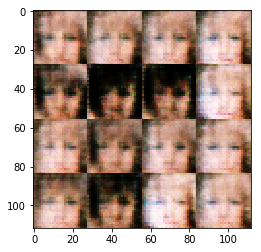

Bacth 610: Epoch 1/1... Discriminator Loss: 1.8793... Generator Loss: 0.6840
Bacth 620: Epoch 1/1... Discriminator Loss: 1.8422... Generator Loss: 0.5760
Bacth 630: Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.7946
Bacth 640: Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 0.7521
Bacth 650: Epoch 1/1... Discriminator Loss: 1.6999... Generator Loss: 0.8301
Bacth 660: Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.7894
Bacth 670: Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7196
Bacth 680: Epoch 1/1... Discriminator Loss: 1.6864... Generator Loss: 0.7507
Bacth 690: Epoch 1/1... Discriminator Loss: 1.7672... Generator Loss: 0.7289
Bacth 700: Epoch 1/1... Discriminator Loss: 2.0828... Generator Loss: 0.6591


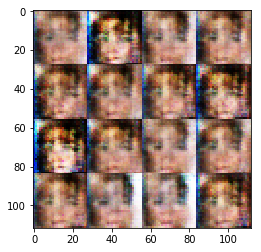

Bacth 710: Epoch 1/1... Discriminator Loss: 1.8914... Generator Loss: 0.6404
Bacth 720: Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 0.7143
Bacth 730: Epoch 1/1... Discriminator Loss: 1.6499... Generator Loss: 0.8757
Bacth 740: Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.7799
Bacth 750: Epoch 1/1... Discriminator Loss: 1.6529... Generator Loss: 0.6468
Bacth 760: Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 0.7554
Bacth 770: Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.8975
Bacth 780: Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 0.6979
Bacth 790: Epoch 1/1... Discriminator Loss: 1.7088... Generator Loss: 0.7347
Bacth 800: Epoch 1/1... Discriminator Loss: 1.9353... Generator Loss: 0.7308


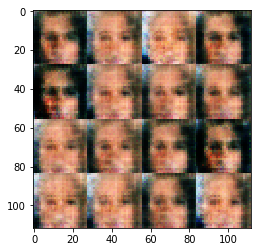

Bacth 810: Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.7173
Bacth 820: Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.9556
Bacth 830: Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.5722
Bacth 840: Epoch 1/1... Discriminator Loss: 1.8112... Generator Loss: 0.7616
Bacth 850: Epoch 1/1... Discriminator Loss: 1.6776... Generator Loss: 0.7610
Bacth 860: Epoch 1/1... Discriminator Loss: 1.7339... Generator Loss: 0.6971
Bacth 870: Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.8672
Bacth 880: Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.6388
Bacth 890: Epoch 1/1... Discriminator Loss: 1.9033... Generator Loss: 0.6625
Bacth 900: Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 0.6862


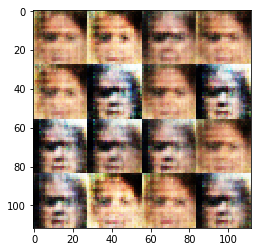

Bacth 910: Epoch 1/1... Discriminator Loss: 1.6298... Generator Loss: 0.7416
Bacth 920: Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.6925
Bacth 930: Epoch 1/1... Discriminator Loss: 1.7636... Generator Loss: 0.6120
Bacth 940: Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.6816
Bacth 950: Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.8237
Bacth 960: Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.9533
Bacth 970: Epoch 1/1... Discriminator Loss: 1.6154... Generator Loss: 0.7872
Bacth 980: Epoch 1/1... Discriminator Loss: 1.7903... Generator Loss: 0.5845
Bacth 990: Epoch 1/1... Discriminator Loss: 1.7546... Generator Loss: 0.7094
Bacth 1000: Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.7154


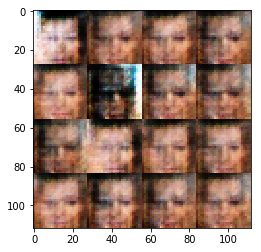

Bacth 1010: Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.8150
Bacth 1020: Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.6017
Bacth 1030: Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.7515
Bacth 1040: Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7546
Bacth 1050: Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.6407
Bacth 1060: Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.6230
Bacth 1070: Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.6671
Bacth 1080: Epoch 1/1... Discriminator Loss: 1.8008... Generator Loss: 0.6259
Bacth 1090: Epoch 1/1... Discriminator Loss: 1.7863... Generator Loss: 0.6528
Bacth 1100: Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.6816


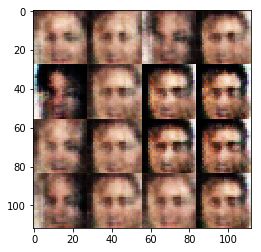

Bacth 1110: Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7674
Bacth 1120: Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.6659
Bacth 1130: Epoch 1/1... Discriminator Loss: 1.6212... Generator Loss: 0.7097
Bacth 1140: Epoch 1/1... Discriminator Loss: 1.7869... Generator Loss: 0.6130
Bacth 1150: Epoch 1/1... Discriminator Loss: 1.8747... Generator Loss: 0.6674
Bacth 1160: Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.7036
Bacth 1170: Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.8207
Bacth 1180: Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.7648
Bacth 1190: Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.7329
Bacth 1200: Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.5582


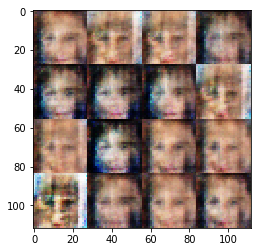

Bacth 1210: Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.8077
Bacth 1220: Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7396
Bacth 1230: Epoch 1/1... Discriminator Loss: 1.7087... Generator Loss: 0.7723
Bacth 1240: Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.8580
Bacth 1250: Epoch 1/1... Discriminator Loss: 1.7566... Generator Loss: 0.6438
Bacth 1260: Epoch 1/1... Discriminator Loss: 1.7054... Generator Loss: 0.6676
Bacth 1270: Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.6978
Bacth 1280: Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.7152
Bacth 1290: Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8077
Bacth 1300: Epoch 1/1... Discriminator Loss: 1.6728... Generator Loss: 0.7141


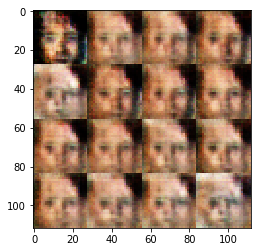

Bacth 1310: Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7379
Bacth 1320: Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.7344
Bacth 1330: Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.7227
Bacth 1340: Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.7446
Bacth 1350: Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.6590
Bacth 1360: Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.7361
Bacth 1370: Epoch 1/1... Discriminator Loss: 1.7129... Generator Loss: 0.6468
Bacth 1380: Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.8289
Bacth 1390: Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.7465
Bacth 1400: Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8623


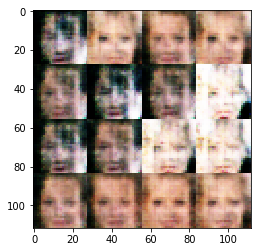

Bacth 1410: Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8972
Bacth 1420: Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7965
Bacth 1430: Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.8421
Bacth 1440: Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7581
Bacth 1450: Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.9365
Bacth 1460: Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.6550
Bacth 1470: Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.7333
Bacth 1480: Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.7342
Bacth 1490: Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 0.6489
Bacth 1500: Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.7235


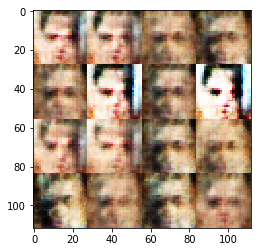

Bacth 1510: Epoch 1/1... Discriminator Loss: 1.7706... Generator Loss: 0.6040
Bacth 1520: Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.9501
Bacth 1530: Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.8019
Bacth 1540: Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.8031
Bacth 1550: Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.7180
Bacth 1560: Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8343
Bacth 1570: Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8305
Bacth 1580: Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6550
Bacth 1590: Epoch 1/1... Discriminator Loss: 1.7155... Generator Loss: 0.6845
Bacth 1600: Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.7326


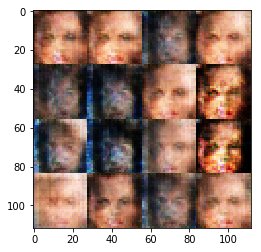

Bacth 1610: Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.6702
Bacth 1620: Epoch 1/1... Discriminator Loss: 1.7411... Generator Loss: 0.6866
Bacth 1630: Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8937
Bacth 1640: Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.7371
Bacth 1650: Epoch 1/1... Discriminator Loss: 1.6674... Generator Loss: 0.7576
Bacth 1660: Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.6767
Bacth 1670: Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.6694
Bacth 1680: Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.7038
Bacth 1690: Epoch 1/1... Discriminator Loss: 1.7320... Generator Loss: 0.6788
Bacth 1700: Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.9621


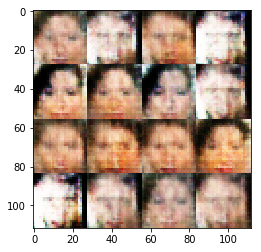

Bacth 1710: Epoch 1/1... Discriminator Loss: 1.6615... Generator Loss: 0.6560
Bacth 1720: Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.7266
Bacth 1730: Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.8310
Bacth 1740: Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8037
Bacth 1750: Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.7403
Bacth 1760: Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.6001
Bacth 1770: Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.7679
Bacth 1780: Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8214
Bacth 1790: Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.8548
Bacth 1800: Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.7783


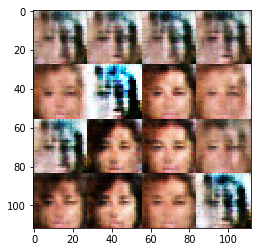

Bacth 1810: Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.7352
Bacth 1820: Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.7544
Bacth 1830: Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8433
Bacth 1840: Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7076
Bacth 1850: Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7830
Bacth 1860: Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.8221
Bacth 1870: Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.7315
Bacth 1880: Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.7238
Bacth 1890: Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.7924
Bacth 1900: Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7530


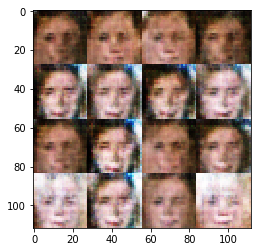

Bacth 1910: Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 0.7820
Bacth 1920: Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.7902
Bacth 1930: Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7049
Bacth 1940: Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.7611
Bacth 1950: Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.7457
Bacth 1960: Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.7578
Bacth 1970: Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.6091
Bacth 1980: Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.8076
Bacth 1990: Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.8622
Bacth 2000: Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.7382


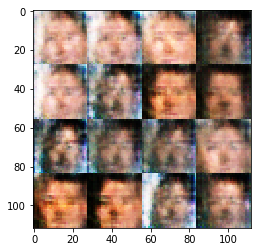

Bacth 2010: Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.8520
Bacth 2020: Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.7939
Bacth 2030: Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.9013
Bacth 2040: Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7716
Bacth 2050: Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.7004
Bacth 2060: Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8700
Bacth 2070: Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7287
Bacth 2080: Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8960
Bacth 2090: Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 0.7557
Bacth 2100: Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.8480


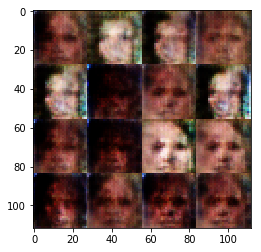

Bacth 2110: Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.8483
Bacth 2120: Epoch 1/1... Discriminator Loss: 1.8819... Generator Loss: 0.6019
Bacth 2130: Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.7148
Bacth 2140: Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.9331
Bacth 2150: Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.8686
Bacth 2160: Epoch 1/1... Discriminator Loss: 1.6878... Generator Loss: 0.6960
Bacth 2170: Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.6656
Bacth 2180: Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 0.6557
Bacth 2190: Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7826
Bacth 2200: Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.7181


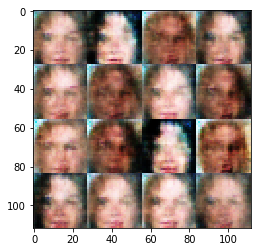

Bacth 2210: Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7538
Bacth 2220: Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.7909
Bacth 2230: Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.7563
Bacth 2240: Epoch 1/1... Discriminator Loss: 1.6877... Generator Loss: 0.7617
Bacth 2250: Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.8067
Bacth 2260: Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.7799
Bacth 2270: Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.7136
Bacth 2280: Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8416
Bacth 2290: Epoch 1/1... Discriminator Loss: 1.6692... Generator Loss: 0.7175
Bacth 2300: Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.7500


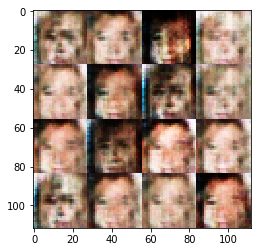

Bacth 2310: Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.7133
Bacth 2320: Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8315
Bacth 2330: Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.7596
Bacth 2340: Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.8235
Bacth 2350: Epoch 1/1... Discriminator Loss: 1.7494... Generator Loss: 0.7430
Bacth 2360: Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8998
Bacth 2370: Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.6723
Bacth 2380: Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.7079
Bacth 2390: Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.8128
Bacth 2400: Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.7145


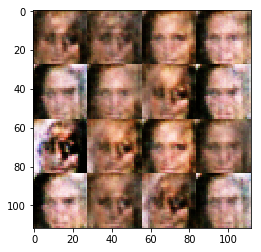

Bacth 2410: Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.8450
Bacth 2420: Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7403
Bacth 2430: Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.8082
Bacth 2440: Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.8056
Bacth 2450: Epoch 1/1... Discriminator Loss: 1.7998... Generator Loss: 0.7362
Bacth 2460: Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8069
Bacth 2470: Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.8459
Bacth 2480: Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.9690
Bacth 2490: Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.8593
Bacth 2500: Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.8858


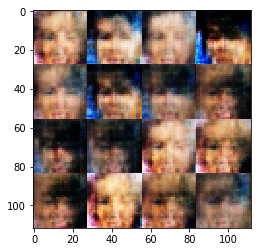

Bacth 2510: Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.7189
Bacth 2520: Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.8716
Bacth 2530: Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.6703
Bacth 2540: Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.6863
Bacth 2550: Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.8002
Bacth 2560: Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7717
Bacth 2570: Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.8203
Bacth 2580: Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.6528
Bacth 2590: Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.7864
Bacth 2600: Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.7765


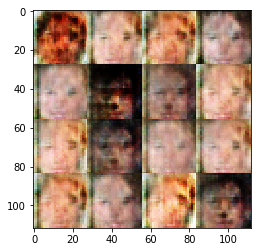

Bacth 2610: Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.8361
Bacth 2620: Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.7476
Bacth 2630: Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.8698
Bacth 2640: Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.9273
Bacth 2650: Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.7769
Bacth 2660: Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.8262
Bacth 2670: Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.8215
Bacth 2680: Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.7450
Bacth 2690: Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7856
Bacth 2700: Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 1.0538


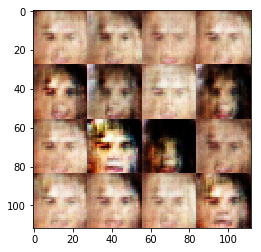

Bacth 2710: Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.7995
Bacth 2720: Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7725
Bacth 2730: Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8873
Bacth 2740: Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.6804
Bacth 2750: Epoch 1/1... Discriminator Loss: 1.6280... Generator Loss: 0.7463
Bacth 2760: Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.7053
Bacth 2770: Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.7465
Bacth 2780: Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.9167
Bacth 2790: Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.8620
Bacth 2800: Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 1.0852


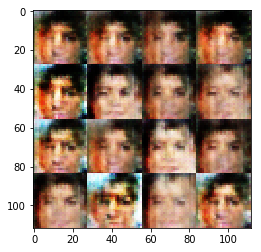

Bacth 2810: Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.8777
Bacth 2820: Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.9231
Bacth 2830: Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7697
Bacth 2840: Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.6110
Bacth 2850: Epoch 1/1... Discriminator Loss: 1.8133... Generator Loss: 0.6458
Bacth 2860: Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.8260
Bacth 2870: Epoch 1/1... Discriminator Loss: 1.6832... Generator Loss: 0.8170
Bacth 2880: Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.7707
Bacth 2890: Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.8101
Bacth 2900: Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.8125


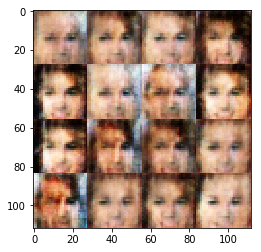

Bacth 2910: Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.7834
Bacth 2920: Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.6861
Bacth 2930: Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7388
Bacth 2940: Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.7887
Bacth 2950: Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 1.0335
Bacth 2960: Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.9332
Bacth 2970: Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6918
Bacth 2980: Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.8259
Bacth 2990: Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.6980
Bacth 3000: Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7606


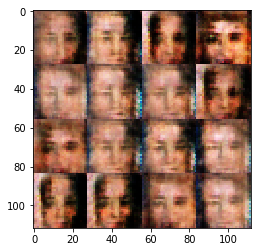

Bacth 3010: Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.8477
Bacth 3020: Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7595
Bacth 3030: Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6775
Bacth 3040: Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.9263
Bacth 3050: Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9409
Bacth 3060: Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8748
Bacth 3070: Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.7368
Bacth 3080: Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.7515
Bacth 3090: Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.7700
Bacth 3100: Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.8421


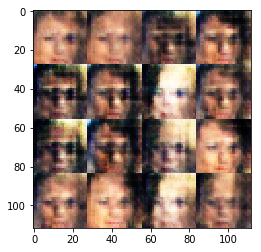

Bacth 3110: Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.9205
Bacth 3120: Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.9001
Bacth 3130: Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.7789
Bacth 3140: Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.9154
Bacth 3150: Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7790
Bacth 3160: Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.8514
Bacth 3170: Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.7180
Bacth 3180: Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.7623
Bacth 3190: Epoch 1/1... Discriminator Loss: 1.7600... Generator Loss: 0.7216
Bacth 3200: Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.8567


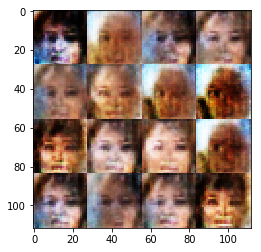

Bacth 3210: Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.7227
Bacth 3220: Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.8879
Bacth 3230: Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.9460
Bacth 3240: Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.8176
Bacth 3250: Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.7158
Bacth 3260: Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.8672
Bacth 3270: Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8581
Bacth 3280: Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8406
Bacth 3290: Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.8067
Bacth 3300: Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.7092


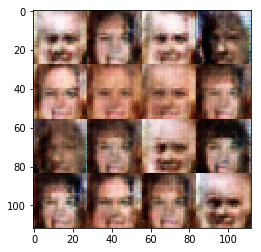

Bacth 3310: Epoch 1/1... Discriminator Loss: 1.6694... Generator Loss: 0.5818
Bacth 3320: Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.8294
Bacth 3330: Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.8202
Bacth 3340: Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.8511
Bacth 3350: Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7303
Bacth 3360: Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.8320
Bacth 3370: Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7929
Bacth 3380: Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8740
Bacth 3390: Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6756
Bacth 3400: Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.7377


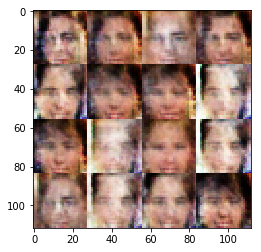

Bacth 3410: Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 0.7580
Bacth 3420: Epoch 1/1... Discriminator Loss: 1.8100... Generator Loss: 0.5164
Bacth 3430: Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.6473
Bacth 3440: Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6706
Bacth 3450: Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.7628
Bacth 3460: Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.7714
Bacth 3470: Epoch 1/1... Discriminator Loss: 1.6161... Generator Loss: 0.7047
Bacth 3480: Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.7650
Bacth 3490: Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.8173
Bacth 3500: Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.8689


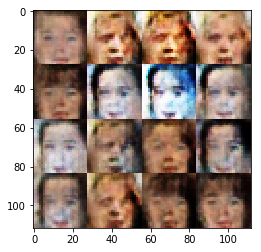

Bacth 3510: Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.8529
Bacth 3520: Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 0.7710
Bacth 3530: Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.7434
Bacth 3540: Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.7925
Bacth 3550: Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8508
Bacth 3560: Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.8242
Bacth 3570: Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7318
Bacth 3580: Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.8111
Bacth 3590: Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.9474
Bacth 3600: Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 0.6629


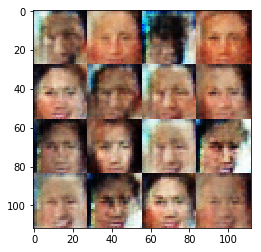

Bacth 3610: Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6705
Bacth 3620: Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7144
Bacth 3630: Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.8999
Bacth 3640: Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.8423
Bacth 3650: Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7455
Bacth 3660: Epoch 1/1... Discriminator Loss: 1.7088... Generator Loss: 0.6390
Bacth 3670: Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.9008
Bacth 3680: Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.8484
Bacth 3690: Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.9380
Bacth 3700: Epoch 1/1... Discriminator Loss: 1.7233... Generator Loss: 0.6300


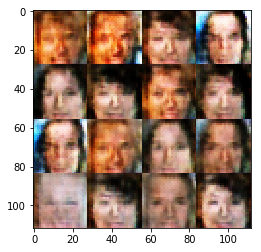

Bacth 3710: Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.7400
Bacth 3720: Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7903
Bacth 3730: Epoch 1/1... Discriminator Loss: 1.8322... Generator Loss: 0.6471
Bacth 3740: Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.0109
Bacth 3750: Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.7424
Bacth 3760: Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.7661
Bacth 3770: Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.8507
Bacth 3780: Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.9420
Bacth 3790: Epoch 1/1... Discriminator Loss: 1.7746... Generator Loss: 0.6638
Bacth 3800: Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.7592


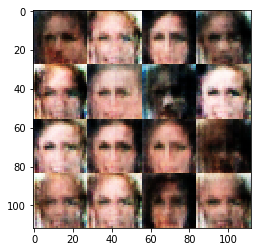

Bacth 3810: Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.8721
Bacth 3820: Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.8072
Bacth 3830: Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.8870
Bacth 3840: Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.7032
Bacth 3850: Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.9129
Bacth 3860: Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 0.6500
Bacth 3870: Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 0.8473
Bacth 3880: Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.9030
Bacth 3890: Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8568
Bacth 3900: Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.7881


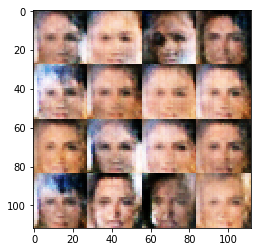

Bacth 3910: Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.7578
Bacth 3920: Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 1.0433
Bacth 3930: Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.8677
Bacth 3940: Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7368
Bacth 3950: Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7586
Bacth 3960: Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.9280
Bacth 3970: Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.9086
Bacth 3980: Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8067
Bacth 3990: Epoch 1/1... Discriminator Loss: 1.5997... Generator Loss: 0.8629
Bacth 4000: Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 1.0097


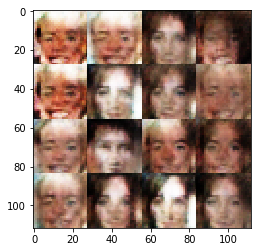

Bacth 4010: Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7772
Bacth 4020: Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.6767
Bacth 4030: Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.7598
Bacth 4040: Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.7887
Bacth 4050: Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.7421
Bacth 4060: Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7684
Bacth 4070: Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.8280
Bacth 4080: Epoch 1/1... Discriminator Loss: 1.8035... Generator Loss: 0.6935
Bacth 4090: Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.9220
Bacth 4100: Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 0.4508


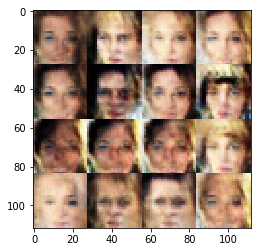

Bacth 4110: Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7056
Bacth 4120: Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7279
Bacth 4130: Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.7465
Bacth 4140: Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.7305
Bacth 4150: Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.7819
Bacth 4160: Epoch 1/1... Discriminator Loss: 1.6988... Generator Loss: 0.7936
Bacth 4170: Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.7913
Bacth 4180: Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.7332
Bacth 4190: Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.8739
Bacth 4200: Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.8009


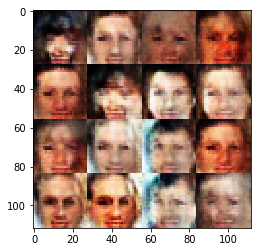

Bacth 4210: Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 1.0261
Bacth 4220: Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.6973
Bacth 4230: Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7406
Bacth 4240: Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8069
Bacth 4250: Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.9675
Bacth 4260: Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.9746
Bacth 4270: Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.7001
Bacth 4280: Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.6971
Bacth 4290: Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.8075
Bacth 4300: Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.8758


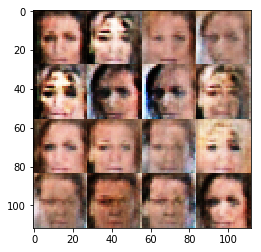

Bacth 4310: Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.6367
Bacth 4320: Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8630
Bacth 4330: Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.6219
Bacth 4340: Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.7446
Bacth 4350: Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7913
Bacth 4360: Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 1.1407
Bacth 4370: Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.7073
Bacth 4380: Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.8005
Bacth 4390: Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 1.0604
Bacth 4400: Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.8799


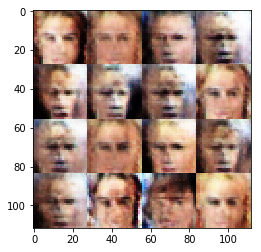

Bacth 4410: Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.6911
Bacth 4420: Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.9260
Bacth 4430: Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.7721
Bacth 4440: Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.8471
Bacth 4450: Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.6788
Bacth 4460: Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6383
Bacth 4470: Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.7365
Bacth 4480: Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.7219
Bacth 4490: Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 1.0578
Bacth 4500: Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.7167


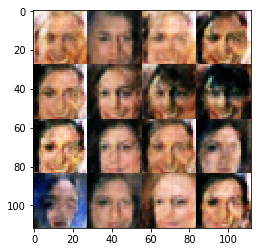

Bacth 4510: Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6877
Bacth 4520: Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7933
Bacth 4530: Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.7608
Bacth 4540: Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.7561
Bacth 4550: Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.8799
Bacth 4560: Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 1.0266
Bacth 4570: Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8951
Bacth 4580: Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8916
Bacth 4590: Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.9877
Bacth 4600: Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.7945


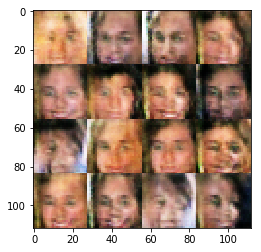

Bacth 4610: Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 0.6980
Bacth 4620: Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 1.1939
Bacth 4630: Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.9006
Bacth 4640: Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7194
Bacth 4650: Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.9064
Bacth 4660: Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.9607
Bacth 4670: Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.7024
Bacth 4680: Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.9550
Bacth 4690: Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7443
Bacth 4700: Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.8517


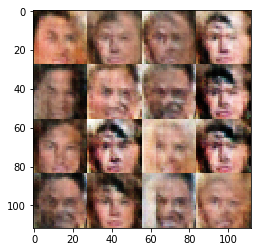

Bacth 4710: Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.6770
Bacth 4720: Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.8004
Bacth 4730: Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 1.0574
Bacth 4740: Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.9361
Bacth 4750: Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.6607
Bacth 4760: Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 1.0063
Bacth 4770: Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.9835
Bacth 4780: Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.7760
Bacth 4790: Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.8454
Bacth 4800: Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.5503


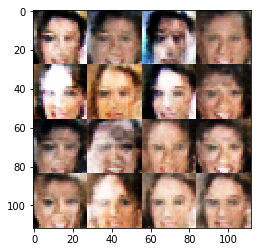

Bacth 4810: Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.8167
Bacth 4820: Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8382
Bacth 4830: Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.7561
Bacth 4840: Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 1.0286
Bacth 4850: Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.8444
Bacth 4860: Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.8395
Bacth 4870: Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.7131
Bacth 4880: Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.7538
Bacth 4890: Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.8429
Bacth 4900: Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.7855


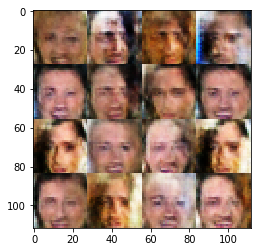

Bacth 4910: Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7550
Bacth 4920: Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.9179
Bacth 4930: Epoch 1/1... Discriminator Loss: 1.6269... Generator Loss: 0.6166
Bacth 4940: Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.8486
Bacth 4950: Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8952
Bacth 4960: Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.9287
Bacth 4970: Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6666
Bacth 4980: Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.9968
Bacth 4990: Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7864
Bacth 5000: Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.7353


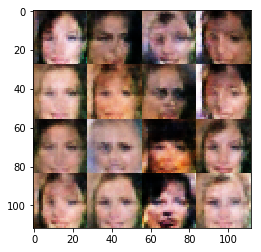

Bacth 5010: Epoch 1/1... Discriminator Loss: 1.7368... Generator Loss: 0.7088
Bacth 5020: Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.8219
Bacth 5030: Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.9060
Bacth 5040: Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 1.0626
Bacth 5050: Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.9899
Bacth 5060: Epoch 1/1... Discriminator Loss: 1.7323... Generator Loss: 0.6168
Bacth 5070: Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6168
Bacth 5080: Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8556
Bacth 5090: Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7588
Bacth 5100: Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.8486


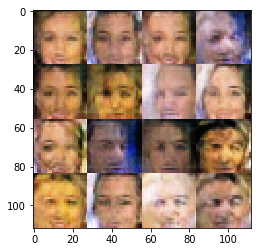

Bacth 5110: Epoch 1/1... Discriminator Loss: 1.6563... Generator Loss: 0.6486
Bacth 5120: Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 1.0724
Bacth 5130: Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8822
Bacth 5140: Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.6338
Bacth 5150: Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9449
Bacth 5160: Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.9271
Bacth 5170: Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 1.0162
Bacth 5180: Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.8247
Bacth 5190: Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.8852
Bacth 5200: Epoch 1/1... Discriminator Loss: 1.6453... Generator Loss: 0.8577


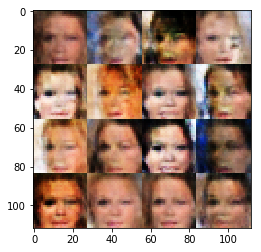

Bacth 5210: Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.9049
Bacth 5220: Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6506
Bacth 5230: Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8146
Bacth 5240: Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.9451
Bacth 5250: Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7135
Bacth 5260: Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 0.7663
Bacth 5270: Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.6988
Bacth 5280: Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.7952
Bacth 5290: Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 1.0733
Bacth 5300: Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.8822


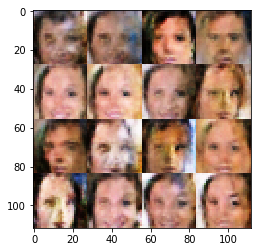

Bacth 5310: Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6602
Bacth 5320: Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.6025
Bacth 5330: Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8035
Bacth 5340: Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.8927
Bacth 5350: Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.7662
Bacth 5360: Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.7479
Bacth 5370: Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.9730
Bacth 5380: Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.8688
Bacth 5390: Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8682
Bacth 5400: Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 0.7516


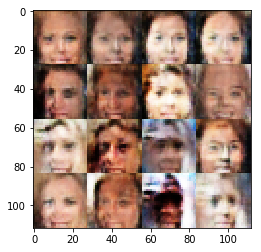

Bacth 5410: Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7638
Bacth 5420: Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.9376
Bacth 5430: Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7873
Bacth 5440: Epoch 1/1... Discriminator Loss: 1.7717... Generator Loss: 0.8495
Bacth 5450: Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.8264
Bacth 5460: Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.7343
Bacth 5470: Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7427
Bacth 5480: Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.6879
Bacth 5490: Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.8979
Bacth 5500: Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 1.0686


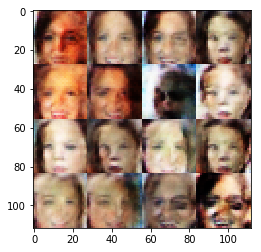

Bacth 5510: Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.8283
Bacth 5520: Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.8511
Bacth 5530: Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8228
Bacth 5540: Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7326
Bacth 5550: Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 1.0394
Bacth 5560: Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 0.6646
Bacth 5570: Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.9109
Bacth 5580: Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.9090
Bacth 5590: Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.7008
Bacth 5600: Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.7956


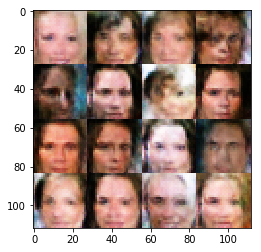

Bacth 5610: Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9872
Bacth 5620: Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 1.0462
Bacth 5630: Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.8172
Bacth 5640: Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.9270
Bacth 5650: Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.8109
Bacth 5660: Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.7060
Bacth 5670: Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.8445
Bacth 5680: Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.8062
Bacth 5690: Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.8012
Bacth 5700: Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 1.0019


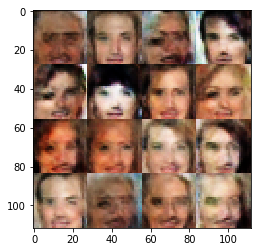

Bacth 5710: Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8646
Bacth 5720: Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.9164
Bacth 5730: Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.8237
Bacth 5740: Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.9872
Bacth 5750: Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 1.3962
Bacth 5760: Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 1.0096
Bacth 5770: Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 1.1294
Bacth 5780: Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7768
Bacth 5790: Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.8296
Bacth 5800: Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.7579


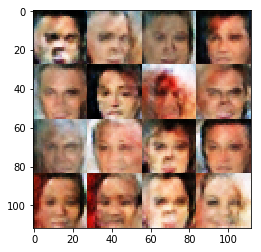

Bacth 5810: Epoch 1/1... Discriminator Loss: 1.6431... Generator Loss: 0.6908
Bacth 5820: Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 1.0910
Bacth 5830: Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.8791
Bacth 5840: Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.9450
Bacth 5850: Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.8365
Bacth 5860: Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.9881
Bacth 5870: Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.7598
Bacth 5880: Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.9475
Bacth 5890: Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.8706
Bacth 5900: Epoch 1/1... Discriminator Loss: 1.7086... Generator Loss: 0.8314


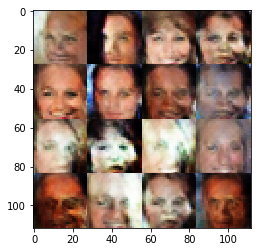

Bacth 5910: Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.9273
Bacth 5920: Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.8292
Bacth 5930: Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.6091
Bacth 5940: Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7619
Bacth 5950: Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.8071
Bacth 5960: Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.7039
Bacth 5970: Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.9098
Bacth 5980: Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.9092
Bacth 5990: Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.9196
Bacth 6000: Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8056


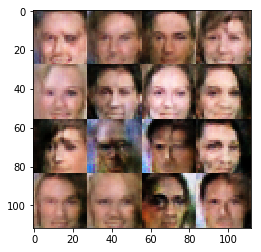

Bacth 6010: Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6900
Bacth 6020: Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.8022
Bacth 6030: Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.9395
Bacth 6040: Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8114
Bacth 6050: Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 1.0817
Bacth 6060: Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.8380
Bacth 6070: Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.8595
Bacth 6080: Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.8054
Bacth 6090: Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.7485
Bacth 6100: Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 1.0391


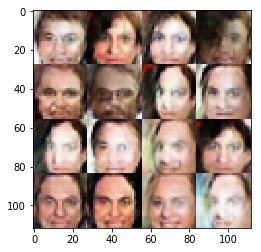

Bacth 6110: Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7199
Bacth 6120: Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7863
Bacth 6130: Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.5872
Bacth 6140: Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.8009
Bacth 6150: Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.9216
Bacth 6160: Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7849
Bacth 6170: Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7774
Bacth 6180: Epoch 1/1... Discriminator Loss: 1.6478... Generator Loss: 0.7270
Bacth 6190: Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.8110
Bacth 6200: Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.7453


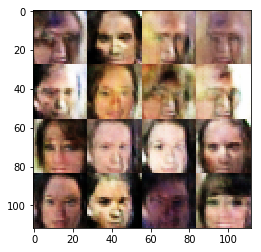

Bacth 6210: Epoch 1/1... Discriminator Loss: 1.5929... Generator Loss: 0.8219
Bacth 6220: Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7256
Bacth 6230: Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.8928
Bacth 6240: Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 1.2431
Bacth 6250: Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.7188
Bacth 6260: Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7251
Bacth 6270: Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.8001
Bacth 6280: Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.9499
Bacth 6290: Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5896
Bacth 6300: Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8539


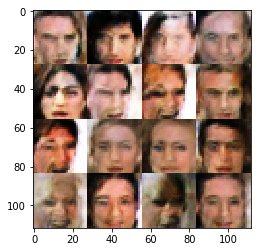

Bacth 6310: Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 1.0428
Bacth 6320: Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.6428
Bacth 6330: Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 1.1835


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.